In [1]:
# Attempting to recover training data using model's parameters and a DCGAN that was trained on similar data
# Author: Suraj Neupane
# Written from scratch as a part of a Research Project 2025, Concordia University of Edmonton.
import numpy as np

import torch
from torch import nn
from torch.nn import functional

from torch.utils import data
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.__version__

'2.5.1+cu118'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

In [5]:
# DCGAN Implementation Class
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super().__init__()
        self.disc = nn.Sequential(
            # Input shape: img_channels x 64 x 64
            nn.Conv2d(
              in_channels=img_channels, out_channels=features_d, kernel_size=4, stride=2, padding=1
            ), # Output shape: features_d x 32 x 32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1), # Output shape: features_d*2 x 16 x 16
            self._block(features_d*2, features_d*4, 4, 2, 1), # Output shape: features_d*4 x 8 x 8
            self._block(features_d*4, features_d*8, 4, 2, 1), # Output shape: features_d*8 x 4 x 4
           
            nn.Conv2d(in_channels=features_d*8, out_channels=1, kernel_size=4, stride=2, padding=0), # Output shape: 1 x 1
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, X):
        return self.disc(X)


In [6]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, features_g):
        super().__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g*16, 4, 1, 0), # z_dim: (batch_size, 100, 1, 1) -> (batch_size, 1024, 4, 4)
            self._block(features_g*16, features_g*8, 4, 2, 1), # z_dim: (batch_size, 1024, 4, 4) -> (batch_size, 512, 8, 8)
            self._block(features_g*8, features_g*4, 4, 2, 1), # z_dim: (batch_size, 512, 8, 8) -> (batch_size, 256, 16, 16)
            self._block(features_g*4, features_g*2, 4, 2, 1), # z_dim: (batch_size, 128, 16, 16) -> (batch_size, 64, 32, 32)
            nn.ConvTranspose2d(
                in_channels=features_g*2, out_channels=img_channels, kernel_size=4, stride=2, padding=1 # z_dim: (batch_size, 64, 32, 32) -> (batch_size, 1, 64, 64)
            ),
            nn.Tanh(),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, X):
        return self.gen(X)

In [7]:
# Hyperparams
z_dim = 100
img_channels = 1
features_disc = 64
features_gen = 64

In [8]:
# Create the model instances
gen = Generator(z_dim, img_channels, features_gen).to(device)
disc = Discriminator(img_channels, features_disc).to(device)

In [9]:
# Load the trained GAN
gen.load_state_dict(torch.load('saved models/Generator.pth', weights_only=True))
disc.load_state_dict(torch.load('saved models/Discriminator.pth', weights_only=True))

<All keys matched successfully>

In [10]:
# Generate a random fake image
noise = torch.randn(1, z_dim, 1, 1).to(device)
fake_img = gen(noise)

In [11]:
fake_img.shape

torch.Size([1, 1, 64, 64])

torch.Size([64, 64])


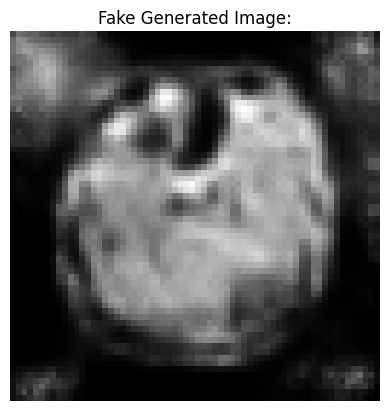

In [12]:
fake_img = fake_img.squeeze()
print(fake_img.shape)
plt.axis(False)
plt.title('Fake Generated Image:')
plt.imshow(fake_img.cpu().detach(), cmap='gray')

In [13]:
# Target Model
class TFCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            Reshape(),
        )

        self.h_size = 64 * 4 * 4

        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(True),
            nn.Linear(128, n_classes)
        )

    def forward(self, xs):
        code = self.encoder(xs)
        logits = self.classifier(code)
        return code, logits


In [14]:
class Reshape(nn.Module):
    def __init__(self,):
        super().__init__()

    def forward(self, xs):
        return xs.reshape((xs.shape[0], -1))

In [15]:
class ClassifyNet(nn.Module):
    def __init__(self, net, init_way, n_classes, input_size=None):
        super().__init__()
        self.net = net
        self.init_way = init_way
        self.n_classes = n_classes

        model = TFCNN(n_classes)

        self.h_size = model.h_size

        # Convo and pool layers
        self.encoder = model.encoder

        # Classifier layer
        self.classifier = nn.Linear(
            self.h_size, self.n_classes, bias=False
        )

        if self.init_way == "orth":
            ws = get_orth_weights(self.h_size, self.n_classes)
            self.classifier.load_state_dict({"weight": ws})

    def forward(self, xs):
        hs = self.encoder(xs)
        logits = self.classifier(hs)
        return hs, logits

In [19]:
def load_target_model(base_net, n_classes, path):
    # Create the base model
    model = ClassifyNet(net=base_net, init_way='none', n_classes=n_classes)
    # Load the model
    model.load_state_dict(torch.load(path, weights_only=True))

    return model

In [23]:
# Target Model Loading
BASE_NET = 'TFCNN'
DATASET = 'tumor4'
N_CLASSES = 4

target_model = load_target_model(base_net=BASE_NET, n_classes=N_CLASSES, path='saved models/feddyn_global_model.path').to(device)
print('Model loaded successfully!')
target_model.eval()

num_params = sum(p.numel() for p in target_model.parameters())
print('Number of parameters in the loaded model:', num_params)


Model loaded successfully!
Number of parameters in the loaded model: 60416


In [24]:
# BEGIN BATCH MODEL INVERSION
img_count = 20
latent_vectors = torch.randn(img_count, z_dim, 1, 1, requires_grad=True) # Start with 20 random noises

In [25]:
def recover_images(count, target_image_class, latent_vectors):
    optimized_latent_vectors = []
    
    for x in range(0, count):
        z = latent_vectors[x].unsqueeze(dim=0).clone().detach().requires_grad_(True)
        
        learning_rate = 0.01
        target_class = 1 # The second class
        
        # Create the optimizer
        optimizer = torch.optim.Adam([z], lr=learning_rate)
        
        # Loss function (e.g., Cross-Entropy with classifier outputs)
        loss_fn = nn.CrossEntropyLoss()
        target_class = torch.tensor([target_image_class])  # Set the target class
    
        # Optimization loop to find the best z
        rounds = 500
        for i in range(rounds):
            optimizer.zero_grad()
            
            generated_image = gen(z.to(device))  # Generate an image from the latent vector
            generated_image = generated_image.repeat(1, 3, 1, 1)
            generated_image = functional.interpolate(generated_image, size=(32, 32), mode='nearest')
            #print(generated_image.shape)
            hs, prediction_logits = target_model(generated_image)  # Classifier output
            #print(prediction_logits)
            #print(type(prediction_logits))
            loss = loss_fn(prediction_logits, target_class.to(device))  # Minimize difference with true class
            loss.backward()
            optimizer.step()
            
            if i % 50 == 0:
                print(f"Generating Image Number: {x+1} for target class {target_class}. Step {i}, Loss: {loss.item()}")
    
        optimized_latent_vectors.append(z)
        
    return optimized_latent_vectors

In [26]:
class0_optimized_latent_vectors = recover_images(img_count, 0, latent_vectors)

Generating Image Number: 1 for target class tensor([0]). Step 0, Loss: 1.1163932085037231
Generating Image Number: 1 for target class tensor([0]). Step 50, Loss: 0.0017256144201382995
Generating Image Number: 1 for target class tensor([0]). Step 100, Loss: 0.0006663962849415839
Generating Image Number: 1 for target class tensor([0]). Step 150, Loss: 0.0004664763400796801
Generating Image Number: 1 for target class tensor([0]). Step 200, Loss: 0.00037150635034777224
Generating Image Number: 1 for target class tensor([0]). Step 250, Loss: 0.00031287543242797256
Generating Image Number: 1 for target class tensor([0]). Step 300, Loss: 0.00026723151677288115
Generating Image Number: 1 for target class tensor([0]). Step 350, Loss: 0.0002330270071979612
Generating Image Number: 1 for target class tensor([0]). Step 400, Loss: 0.00020823694649152458
Generating Image Number: 1 for target class tensor([0]). Step 450, Loss: 0.00019143179815728217
Generating Image Number: 2 for target class tensor(

In [27]:
torch.manual_seed(100)
latent_vectors = torch.randn(img_count, z_dim, 1, 1, requires_grad=True) # Start with 20 random noises
class1_optimized_latent_vectors = recover_images(img_count, 1, latent_vectors)

Generating Image Number: 1 for target class tensor([1]). Step 0, Loss: 0.06038965284824371
Generating Image Number: 1 for target class tensor([1]). Step 50, Loss: 5.8530047681415454e-05
Generating Image Number: 1 for target class tensor([1]). Step 100, Loss: 4.100715523236431e-05
Generating Image Number: 1 for target class tensor([1]). Step 150, Loss: 3.325883881188929e-05
Generating Image Number: 1 for target class tensor([1]). Step 200, Loss: 2.7656173188006505e-05
Generating Image Number: 1 for target class tensor([1]). Step 250, Loss: 2.276871418871451e-05
Generating Image Number: 1 for target class tensor([1]). Step 300, Loss: 1.8000440832111053e-05
Generating Image Number: 1 for target class tensor([1]). Step 350, Loss: 1.4781842764932662e-05
Generating Image Number: 1 for target class tensor([1]). Step 400, Loss: 1.2755313036905136e-05
Generating Image Number: 1 for target class tensor([1]). Step 450, Loss: 1.1324817933200393e-05
Generating Image Number: 2 for target class tenso

In [28]:
torch.manual_seed(200)
latent_vectors = torch.randn(img_count, z_dim, 1, 1, requires_grad=True) # Start with 20 random noises
class2_optimized_latent_vectors = recover_images(img_count, 2, latent_vectors)

Generating Image Number: 1 for target class tensor([2]). Step 0, Loss: 4.753173828125
Generating Image Number: 1 for target class tensor([2]). Step 50, Loss: 0.321609228849411
Generating Image Number: 1 for target class tensor([2]). Step 100, Loss: 0.1443520188331604
Generating Image Number: 1 for target class tensor([2]). Step 150, Loss: 0.09008529037237167
Generating Image Number: 1 for target class tensor([2]). Step 200, Loss: 0.07085629552602768
Generating Image Number: 1 for target class tensor([2]). Step 250, Loss: 0.06019705906510353
Generating Image Number: 1 for target class tensor([2]). Step 300, Loss: 0.05320969969034195
Generating Image Number: 1 for target class tensor([2]). Step 350, Loss: 0.04630543664097786
Generating Image Number: 1 for target class tensor([2]). Step 400, Loss: 0.04126417264342308
Generating Image Number: 1 for target class tensor([2]). Step 450, Loss: 0.03247733786702156
Generating Image Number: 2 for target class tensor([2]). Step 0, Loss: 2.33574724

In [29]:
torch.manual_seed(300)
latent_vectors = torch.randn(img_count, z_dim, 1, 1, requires_grad=True) # Start with 20 random noises
class3_optimized_latent_vectors = recover_images(img_count, 3, latent_vectors)

Generating Image Number: 1 for target class tensor([3]). Step 0, Loss: 0.5773957371711731
Generating Image Number: 1 for target class tensor([3]). Step 50, Loss: 0.01294118445366621
Generating Image Number: 1 for target class tensor([3]). Step 100, Loss: 0.005129273049533367
Generating Image Number: 1 for target class tensor([3]). Step 150, Loss: 0.003107839496806264
Generating Image Number: 1 for target class tensor([3]). Step 200, Loss: 0.001891610911116004
Generating Image Number: 1 for target class tensor([3]). Step 250, Loss: 0.001168402610346675
Generating Image Number: 1 for target class tensor([3]). Step 300, Loss: 0.0009263038518838584
Generating Image Number: 1 for target class tensor([3]). Step 350, Loss: 0.0008008848526515067
Generating Image Number: 1 for target class tensor([3]). Step 400, Loss: 0.0006990373367443681
Generating Image Number: 1 for target class tensor([3]). Step 450, Loss: 0.0006272017490118742
Generating Image Number: 2 for target class tensor([3]). Step 

In [30]:
z0_1 = class0_optimized_latent_vectors[0]
z0_2 = class0_optimized_latent_vectors[1]
z0_3 = class0_optimized_latent_vectors[2]

In [31]:
# Display the generated image
img = gen(z0_1.to(device)).squeeze(dim=0).squeeze(dim=0)
print(img.shape)

torch.Size([64, 64])


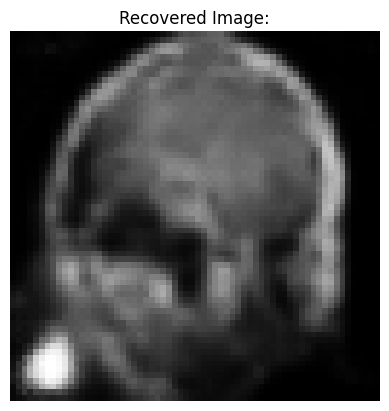

In [32]:
plt.axis(False)
plt.title('Recovered Image:')
plt.imshow(img.cpu().detach(), cmap='gray')

In [33]:
z1 = class1_optimized_latent_vectors[0]
z2 = class1_optimized_latent_vectors[1]
z3 = class1_optimized_latent_vectors[2]

In [34]:
# Display the generated image
img = gen(z1.to(device)).squeeze(dim=0).squeeze(dim=0)
print(img.shape)

torch.Size([64, 64])


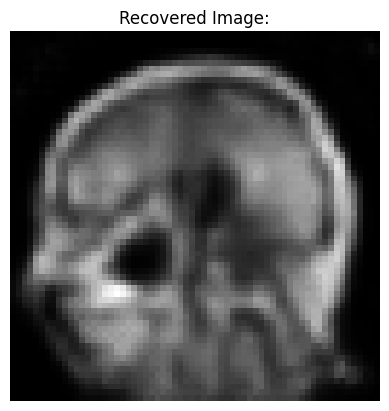

In [35]:
plt.axis(False)
plt.title('Recovered Image:')
plt.imshow(img.cpu().detach(), cmap='gray')

In [36]:
                                                            # Dataset Loading
# Load the .pkl files in as numpy arrays of pixels
def load_tumor_data(file_path):
    train_xs = []
    train_ys = []
    """ Load Digits Data from pickle data
    return:
    @xs: numpy.array, (n, c, w, h) 
    @ys: numpy.array, (n, ), 0-9
    """
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        train_xs.append(data["data"])
        train_ys.append(data["labels"])
    train_xs = np.concatenate(train_xs, axis=0)
    train_ys = np.concatenate(train_ys, axis=0)
    
    return train_xs, train_ys

In [37]:
# Custom Tumor Dataset
class TumorDataset(data.Dataset):
    def __init__(self, xs, ys, is_train=True):
        self.xs = xs
        self.ys = ys

        if is_train is True:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.5],
                    [0.5]
                )
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.4914, 0.4822, 0.4465),
                    (0.2023, 0.1994, 0.2010)
                )
            ])

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, index):
        img = self.xs[index]
        #print(img.shape)
        label = self.ys[index]

        img = img.transpose((1, 2, 0)).astype(np.uint8)
        img = self.transform(img)

        img = torch.FloatTensor(img)
        label = torch.LongTensor([label])[0]
        return img, label

In [38]:
def create_dataset(train_xs, train_ys):
    tumor_dataset = TumorDataset(train_xs, train_ys, is_train=True)

    return tumor_dataset

In [39]:
def create_dataloader(dataset):
    dataloader = DataLoader(dataset=dataset, batch_size=128, shuffle=True)

    return dataloader

In [40]:
# Load in the pickle dataset file
train_xs, train_ys = load_tumor_data('datasets/Tumor/tumor4train.pkl')
#train_xs = train_xs[:, 1, :, :]
#train_xs = np.expand_dims(train_xs, axis=1)
train_xs = train_xs.mean(axis=1, keepdims=True)
print(train_xs.shape)
print(type(train_xs))

(13927, 1, 32, 32)
<class 'numpy.ndarray'>


In [41]:
# Create the dataset
tumor_dataset = create_dataset(train_xs, train_ys)

In [42]:
def visualize_image(image_x):
    # We have to visualize by reverting the normalization (just for visualization).
    mean = torch.tensor([0.5])
    std = torch.tensor([0.5])

    image = image_x * std + mean  # Denormalize the image

    image = torch.clamp(image, 0, 1) # Clip values to [0, 1] to ensure valid range for display

    # Permute the image to (H, W, C) for matplotlib
    
    image = image.permute(1, 2, 0)

    plt.imshow(image, cmap='gray')

torch.Size([1, 64, 64])


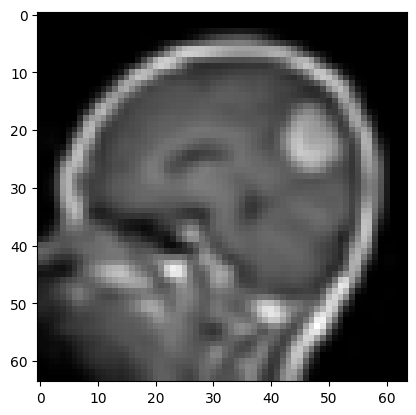

In [43]:
# Visualize the first tumor sample. 
image_x, image_y = tumor_dataset[7000]
print(image_x.shape)
visualize_image(image_x)

In [44]:
from scipy.spatial.distance import cosine

In [45]:
# Get the feature embeddings
tfcnn_model = target_model = load_target_model(base_net='TFCNN', n_classes=4, path='saved models/fedavg_global_model.pth').to(device)
model_embeddings = tfcnn_model.encoder.to(device)

In [46]:
# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

In [47]:
def get_feature(img):
    with torch.no_grad():
        features = model_embeddings(img).squeeze()
    return features.cpu().numpy()

In [48]:
# Send an original image through the model
image_x, image_y = tumor_dataset[10]
image_x.shape

torch.Size([1, 64, 64])

In [49]:
image_x = image_x.unsqueeze(dim=0)

In [50]:
image_x.shape

torch.Size([1, 1, 64, 64])

In [51]:
image_x = image_x.repeat(1, 3, 1, 1)
image_x = image_x.to(device)
image_x.shape

torch.Size([1, 3, 64, 64])

In [52]:
features = get_feature(image_x)
features.shape

(4096,)

In [53]:
class0_original_images = []
class1_original_images = []
class2_original_images = []
class3_original_images = []
target_num = 20 # 20 images for each class

In [54]:
for i in range(len(tumor_dataset)):
    img_x, img_y = tumor_dataset[i]

    if img_y == 0:
        if len(class0_original_images) < target_num:
            class0_original_images.append(img_x)
    elif img_y == 1:
        if len(class1_original_images) < target_num:
            class1_original_images.append(img_x)
    elif img_y == 2:
        if len(class2_original_images) < target_num:
            class2_original_images.append(img_x)
    elif img_y == 3:
        if len(class3_original_images) < target_num:
            class3_original_images.append(img_x)

In [55]:
len(class3_original_images)

20

In [56]:
# Testing the cosine similarity
class1_original_image = class1_original_images[8]
class1_original_image = class1_original_image.unsqueeze(dim=0).to(device)
class1_original_image = class1_original_image.repeat(1, 3, 1, 1)
class1_original_image.shape

torch.Size([1, 3, 64, 64])

In [57]:
fake1 = class1_optimized_latent_vectors[8]
fake1_image = gen(fake1.to(device))
fake1_image = fake1_image.repeat(1, 3, 1, 1)

In [58]:
fake1_image.shape

torch.Size([1, 3, 64, 64])

In [59]:
# Get the features of the images
features_original = get_feature(class1_original_image)
features_fake = get_feature(fake1_image)

In [60]:
# Compute cosine similarity
similarity = 1 - cosine(features_original, features_fake)

In [61]:
similarity

np.float32(0.31079966)

In [62]:
def calculate_class0_sim():
    similarities = []
    for i in range(0, 20):
        class0_original = class0_original_images[i].unsqueeze(dim=0).to(device)
        class0_original = class0_original.repeat(1, 3, 1, 1)

        class0_fake = class0_optimized_latent_vectors[i]
        class0_fake_img = gen(class0_fake.to(device))
        class0_fake_img = class0_fake_img.repeat(1, 3, 1, 1)

        features_original = get_feature(class0_original)
        features_fake = get_feature(class0_fake_img)

        cosine_similarity = 1 - cosine(features_original, features_fake)

        similarities.append(cosine_similarity)
        
    return similarities

In [63]:
def calculate_class1_sim():
    similarities = []
    for i in range(0, 20):
        class1_original = class1_original_images[i].unsqueeze(dim=0).to(device)
        class1_original = class1_original.repeat(1, 3, 1, 1)

        class1_fake = class1_optimized_latent_vectors[i]
        class1_fake_img = gen(class1_fake.to(device))
        class1_fake_img = class1_fake_img.repeat(1, 3, 1, 1)

        features_original = get_feature(class1_original)
        features_fake = get_feature(class1_fake_img)

        cosine_similarity = 1 - cosine(features_original, features_fake)
        similarities.append(cosine_similarity)

    return similarities

In [64]:
def calculate_class2_sim():
    similarities = []
    for i in range(0, 20):
        class2_original = class2_original_images[i].unsqueeze(dim=0).to(device)
        class2_original = class2_original.repeat(1, 3, 1, 1)

        class2_fake = class2_optimized_latent_vectors[i]
        class2_fake_img = gen(class2_fake.to(device))
        class2_fake_img = class2_fake_img.repeat(1, 3, 1, 1)

        features_original = get_feature(class2_original)
        features_fake = get_feature(class2_fake_img)

        cosine_similarity = 1 - cosine(features_original, features_fake)
        similarities.append(cosine_similarity)

    return similarities

In [65]:
def calculate_class3_sim():
    similarities = []
    for i in range(0, 20):
        class3_original = class3_original_images[i].unsqueeze(dim=0).to(device)
        class3_original = class3_original.repeat(1, 3, 1, 1)

        class3_fake = class3_optimized_latent_vectors[i]
        class3_fake_img = gen(class3_fake.to(device))
        class3_fake_img = class3_fake_img.repeat(1, 3, 1, 1)

        features_original = get_feature(class3_original)
        features_fake = get_feature(class3_fake_img)

        cosine_similarity = 1 - cosine(features_original, features_fake)
        similarities.append(cosine_similarity)

    return similarities

In [66]:
class0_sims = calculate_class0_sim()
class1_sims = calculate_class0_sim()
class2_sims = calculate_class0_sim()
class3_sims = calculate_class0_sim()

In [67]:
class0_sims

[np.float32(0.27501023),
 np.float32(0.34416473),
 np.float32(0.27307427),
 np.float32(0.32048547),
 np.float32(0.22351396),
 np.float32(0.4125042),
 np.float32(0.20725214),
 np.float32(0.35783535),
 np.float32(0.425151),
 np.float32(0.27823532),
 np.float32(0.4095149),
 np.float32(0.29026735),
 np.float32(0.39925706),
 np.float32(0.32008857),
 np.float32(0.38158906),
 np.float32(0.44531876),
 np.float32(0.44554722),
 np.float32(0.33217347),
 np.float32(0.2716192),
 np.float32(0.2541002)]

In [68]:
class3_sims

[np.float32(0.2750101),
 np.float32(0.34416503),
 np.float32(0.27307427),
 np.float32(0.32048494),
 np.float32(0.22351396),
 np.float32(0.4125042),
 np.float32(0.20725214),
 np.float32(0.35783535),
 np.float32(0.42515063),
 np.float32(0.27823532),
 np.float32(0.40951478),
 np.float32(0.29026747),
 np.float32(0.39925706),
 np.float32(0.32008857),
 np.float32(0.38158906),
 np.float32(0.4453187),
 np.float32(0.4455464),
 np.float32(0.33217347),
 np.float32(0.2716192),
 np.float32(0.2541002)]

FileNotFoundError: [Errno 2] No such file or directory: 'output/fedvg.png'

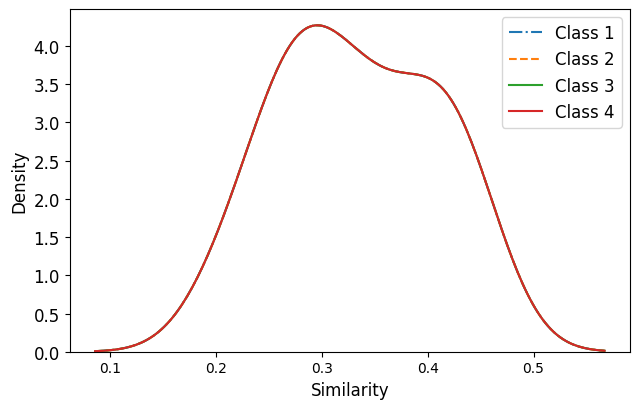

In [69]:
                                                        # VISUALIZE
# NOTE: Class indexes now start from 1 so, previous class 0 = now class 1 and so on
# FIG 1: Raw similarity plot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate sample similarity data for four classes (each with 20 values in the range 0 to 1)
class1_sim = class0_sims
class2_sim = class1_sims
class3_sim = class2_sims
class4_sim = class3_sims

# Set figure size
plt.figure(figsize=(6.5, 4.2))  # Set the size of the figure (width, height)

# Sample DataFrame with four columns
data=pd.DataFrame({'Class 1':class1_sim,'Class 2':class2_sim,'Class 3':class3_sim,'Class 4':class4_sim})
df = pd.DataFrame(data)

# Plot the probability distributions
#plt.figure(figsize=(10, 6))

# Define colors and line styles for each column
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
linestyles = ['-.', '--', '-', '-']

# Plot the probability distributions with unique colors and line styles
for column, color, linestyle in zip(df.columns, colors, linestyles):
    sns.kdeplot(df[column], label=column, color=color, linestyle=linestyle)

#plt.title('Probability Distributions of Four Columns')
plt.xlabel('Similarity',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.yticks(fontsize=12)  # Set y-tick labels font size
plt.legend(loc='upper right',fontsize=12)  # Increase legend font size

# Optimize layout
plt.tight_layout()
# Save the plot to a file
plt.savefig('output/fedvg.png', dpi=300, bbox_inches='tight')  # Save as a PNG file with high resolution

# Show the plot
plt.show()


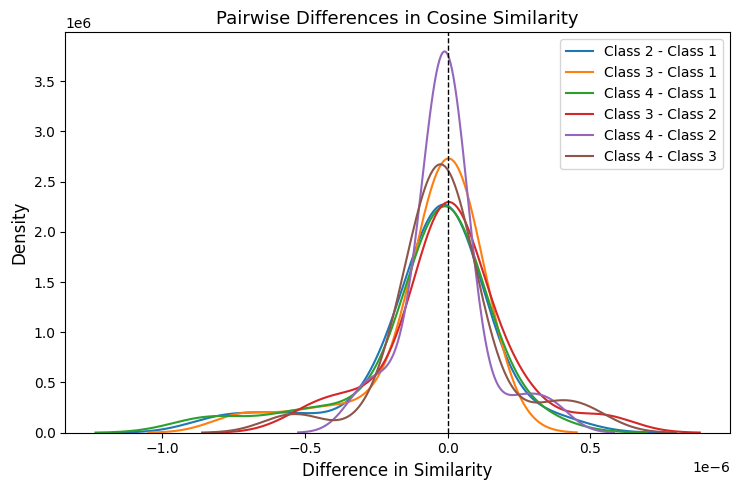

In [70]:
# FIG 2: DIFFERENCES IN COSINE SIMILARITY

# For each class, we have 20 similarity values — one per image — showing how similar fake and real versions are.These values are very close across classes
# So, to highlight subtle differences, compute and plot the difference between each pair of classes, value by value.
# This gives you 20 values showing how much the similarity differs for each image between class 0 and class 1.
# It's a magnified view of the gap between classes.
# If the differences are tiny (e.g., 0.003), the plot helps make that visible and comparable.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Differences between class distributions (pairwise)
diff_12 = np.array(class2_sim) - np.array(class1_sim)
diff_13 = np.array(class3_sim) - np.array(class1_sim)
diff_14 = np.array(class4_sim) - np.array(class1_sim)
diff_23 = np.array(class3_sim) - np.array(class2_sim)
diff_24 = np.array(class4_sim) - np.array(class2_sim)
diff_34 = np.array(class4_sim) - np.array(class3_sim)

# Create a DataFrame
diff_df = pd.DataFrame({
    'Class 2 - Class 1': diff_12,
    'Class 3 - Class 1': diff_13,
    'Class 4 - Class 1': diff_14,
    'Class 3 - Class 2': diff_23,
    'Class 4 - Class 2': diff_24,
    'Class 4 - Class 3': diff_34,
})

# Plot
plt.figure(figsize=(7.5, 5))

colors = sns.color_palette("tab10", n_colors=6)

for column, color in zip(diff_df.columns, colors):
    sns.kdeplot(diff_df[column], label=column, color=color, linestyle='-')

plt.axvline(0, color='black', linestyle='--', linewidth=1)  # reference line at 0
plt.xlabel('Difference in Similarity', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.title("Pairwise Differences in Cosine Similarity", fontsize=13)
plt.tight_layout()
plt.show()

In [71]:
def calculate_interclass_similarity(first, second):
    similarities = []

    first_images = []
    second_images = []
    if first == 'class1':
        first_images = class0_original_images.copy()
    elif first == 'class2':
        first_images = class1_original_images.copy()
    elif first == 'class3':
        first_images = class2_original_images.copy()
    elif first == 'class4':
        first_images = class3_original_images.copy()

    if second == 'class1':
        second_images = class0_original_images.copy()
    elif second == 'class2':
        second_images = class1_original_images.copy()
    elif second == 'class3':
        second_images = class2_original_images.copy()
    elif second == 'class4':
        second_images = class3_original_images.copy()
    
    for i in range(0, 20):
        first_image = first_images[i].unsqueeze(dim=0).to(device)
        first_image = first_image.repeat(1, 3, 1, 1)
        
        second_image = second_images[i].unsqueeze(dim=0).to(device)
        second_image = second_image.repeat(1, 3, 1, 1)
        
        features_first = get_feature(first_image)
        features_second = get_feature(second_image)

        cosine_similarity = 1 - cosine(features_first, features_second)
        similarities.append(cosine_similarity)

    return similarities

In [72]:
class1class2 = calculate_interclass_similarity('class1', 'class2')

In [73]:
class1class2

[np.float32(0.92668736),
 np.float32(0.9234537),
 np.float32(0.8914366),
 np.float32(0.85996324),
 np.float32(0.9045878),
 np.float32(0.8661933),
 np.float32(0.8529511),
 np.float32(0.8320824),
 np.float32(0.81313324),
 np.float32(0.9028811),
 np.float32(0.9157124),
 np.float32(0.83247995),
 np.float32(0.9164997),
 np.float32(0.84919524),
 np.float32(0.90398437),
 np.float32(0.8242637),
 np.float32(0.78115076),
 np.float32(0.80533254),
 np.float32(0.92938054),
 np.float32(0.89034694)]

FileNotFoundError: [Errno 2] No such file or directory: 'output/VoiceDivergenceD3.png'

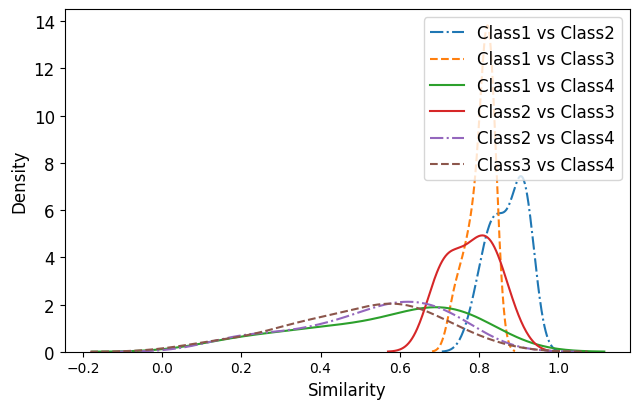

In [75]:
                                                # FIG: 3 -> INTERCLASS SIMILARITIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(6.5, 4.2))  # Set the size of the figure (width, height)

# Generate sample similarity data for four classes (each with 20 values in the range 0 to 1)
np.random.seed(42)  # For reproducibility
class1class2 = calculate_interclass_similarity('class1', 'class2')
class1class3 = calculate_interclass_similarity('class1', 'class3')
class1class4 = calculate_interclass_similarity('class1', 'class4')
class2class3 = calculate_interclass_similarity('class2', 'class3')
class2class4 = calculate_interclass_similarity('class2', 'class4')
class3class4 = calculate_interclass_similarity('class3', 'class4')

# Sample DataFrame with four columns
data=pd.DataFrame({'Class1 vs Class2':class1class2,'Class1 vs Class3':class1class3,'Class1 vs Class4':class1class4,'Class2 vs Class3':class2class3,'Class2 vs Class4':class2class4,'Class3 vs Class4':class3class4})
df = pd.DataFrame(data)

# Plot the probability distributions
#plt.figure(figsize=(10, 6))

# Define colors and line styles for each column
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
linestyles = ['-.', '--', '-', '-', '-.', '--']

# Plot the probability distributions with unique colors and line styles
for column, color, linestyle in zip(df.columns, colors, linestyles):
    sns.kdeplot(df[column], label=column, color=color, linestyle=linestyle)

#plt.title('Probability Distributions of Four Columns')
plt.xlabel('Similarity',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.yticks(fontsize=12)  # Set y-tick labels font size
plt.legend(loc='upper right',fontsize=12)  # Increase legend font size

# Optimize layout
plt.tight_layout()
# Save the plot to a file
plt.savefig('output/VoiceDivergenceD3.png', dpi=300, bbox_inches='tight')  # Save as a PNG file with high resolution

# Show the plot
plt.show()